In [2]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [4]:
# Load your dataset (ensure this path is correct)
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

In [5]:
# Rescale and reshape the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input (Ensure correct shape for MobileNetV2)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Resize images to at least 96x96 pixels for MobileNetV2
X_resized = tf.image.resize(X_reshaped, [96, 96]).numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

In [11]:
# Load MobileNetV2 model pre-trained on ImageNet (exclude the top layers)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Unfreeze some layers of the MobileNetV2 model for fine-tuning (consider unfreezing more layers)
for layer in mobilenet_base.layers[-20:]:  # Unfreeze the last 20 layers for fine-tuning
    layer.trainable = True


In [7]:
from tensorflow.keras.regularizers import l2  # Import L2 regularization

# Build the model using Sequential with additional regularization
model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),  # Global pooling to reduce spatial dimensions
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization added
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # L2 regularization on the output layer
])

In [8]:
# Compile the model with the same optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Define Data Generator for Data Augmentation with enhanced transformations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

In [13]:
#Define Learning Rate Reduction and Early Stopping for better convergence
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on validation data
        y_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        y_true = self.validation_data[1]

        # Print classification report metrics: precision, recall, f1-score
        report = classification_report(y_true, y_pred, output_dict=True,zero_division=0)
        print(f"Epoch {epoch + 1} Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")

# Create an instance of the MetricsCallback and set validation data for it
metrics_callback = MetricsCallback()
metrics_callback.validation_data = (X_test, y_test)


In [14]:
# Train the model with augmented data and callbacks
batch_size = 32  # Experiment with this value if needed; smaller sizes can improve generalization.
epochs = 30  # Increased epochs for better model training

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping, metrics_callback]
)



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step
Epoch 1 Classification Report:
Precision: 0.7198, Recall: 0.5805, F1-Score: 0.6427
251/251 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.6290 - loss: 0.9279 - val_accuracy: 0.6820 - val_loss: 0.8156 - learning_rate: 1.0000e-04
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step
Epoch 2 Classification Report:
Precision: 0.7338, Recall: 0.7791, F1-Score: 0.7558
251/251 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.7803 - loss: 0.6796 - val_accuracy: 0.7519 - val_loss: 0.7358 - learning_rate: 1.0000e-04
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step
Epoch 3 Classification Report:
Precision: 0.7140, Recall: 0.8349, F1-Score: 0.7697
251/251 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.8005 - loss: 0.6181 - val_accuracy: 0.7539 - val_loss: 0.7258 - learning_rate: 1.0000e-04
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step
Epoch 4 Classification Report:
Precision: 0.6912, Recall: 0.9119, F1-Score: 0.7864
251/251 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# Evaluate the model on the test set and print results
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.8991 - loss: 0.3782
Test Accuracy: 91.11%


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,198,021 (27.46 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,775,940 (18.22 MB)

In [24]:
model.save("FINAL_MOBILE NET_model.h5")
model.save('FINAL_MOBILE NET_model.keras')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f" Accuracy: {train_accuracy:.4f},Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f" Accuracy: {test_accuracy:.4f},Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step
Training Metrics:
 Accuracy: 0.9822,Precision: 0.9824, Recall: 0.9822, F1-Score: 0.9821

Testing Metrics:
 Accuracy: 0.9111,Precision: 0.9115, Recall: 0.9111, F1-Score: 0.9111


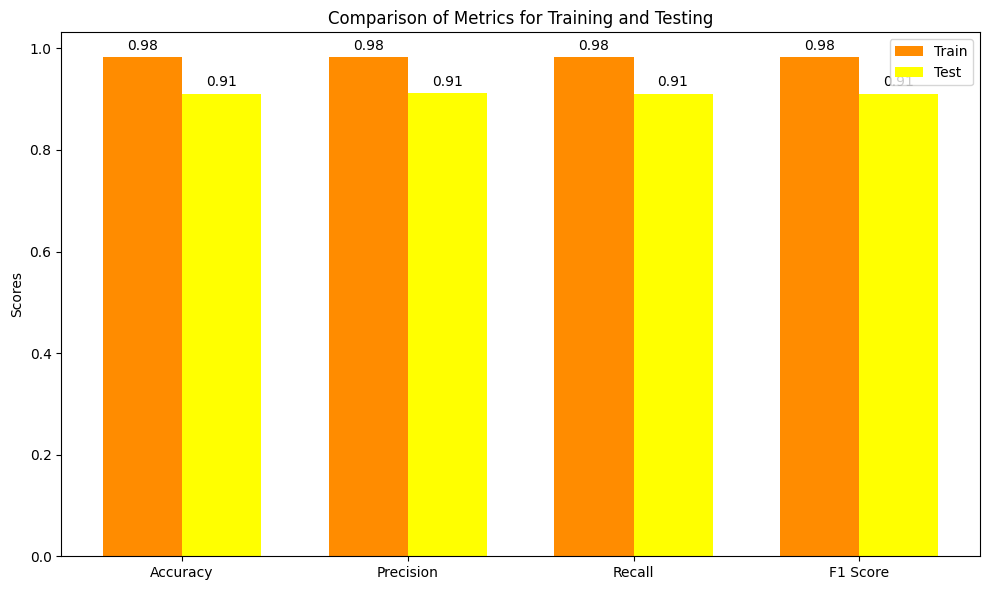

In [19]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='darkorange')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='yellow')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities and binary classes
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.8991 - loss: 0.3782
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1016
           1       0.92      0.89      0.91       987

    accuracy                           0.91      2003
   macro avg       0.91      0.91      0.91      2003
weighted avg       0.91      0.91      0.91      2003



63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step


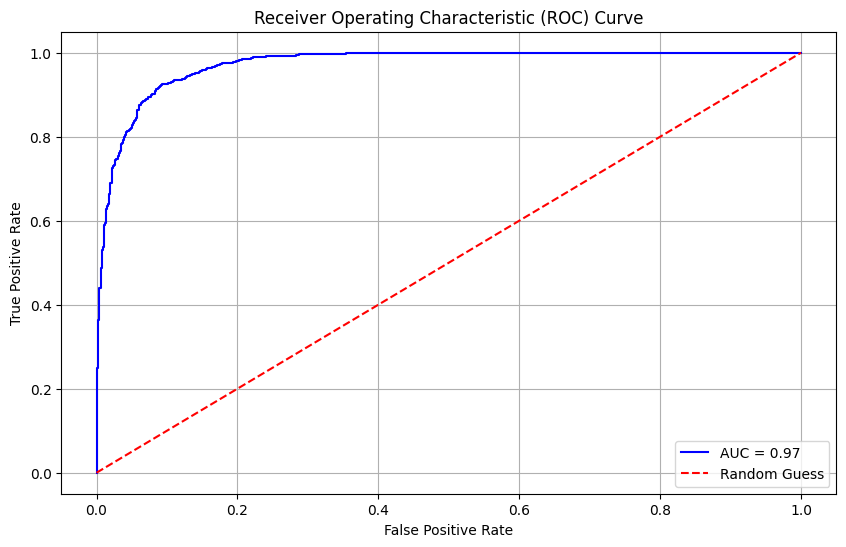

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).flatten()

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step


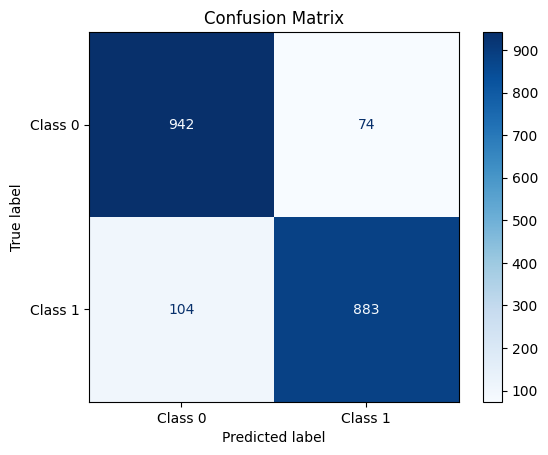

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()